# Import liblibraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


# load data and preprocessing

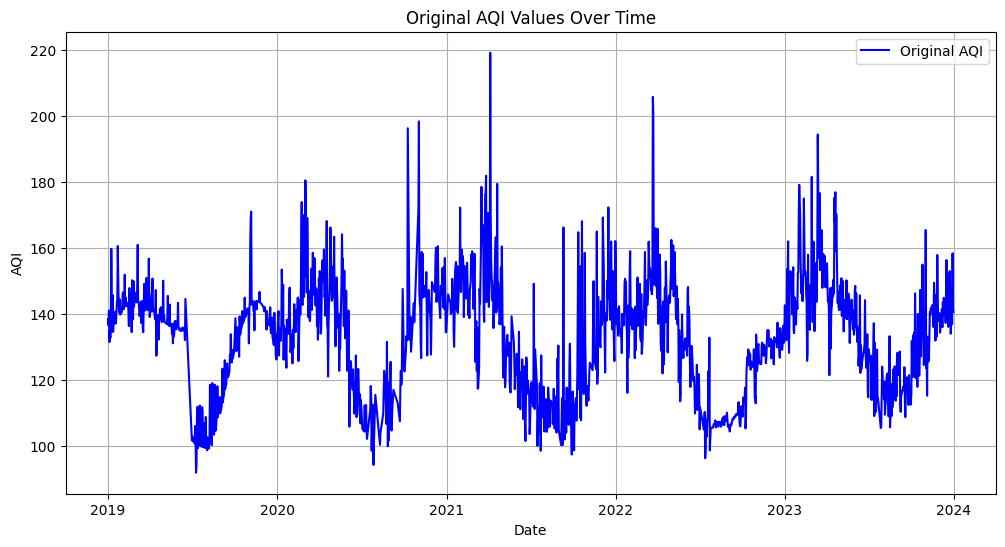

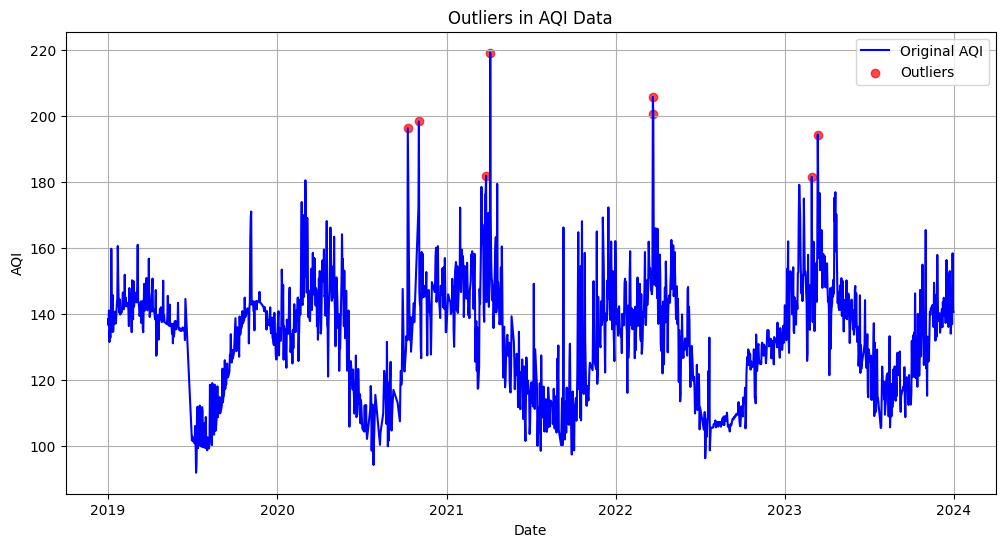

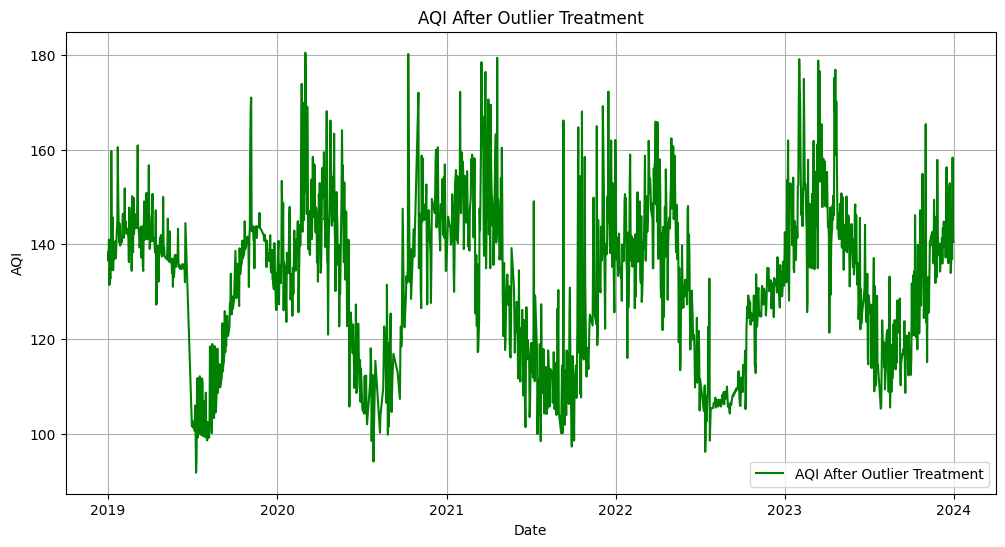

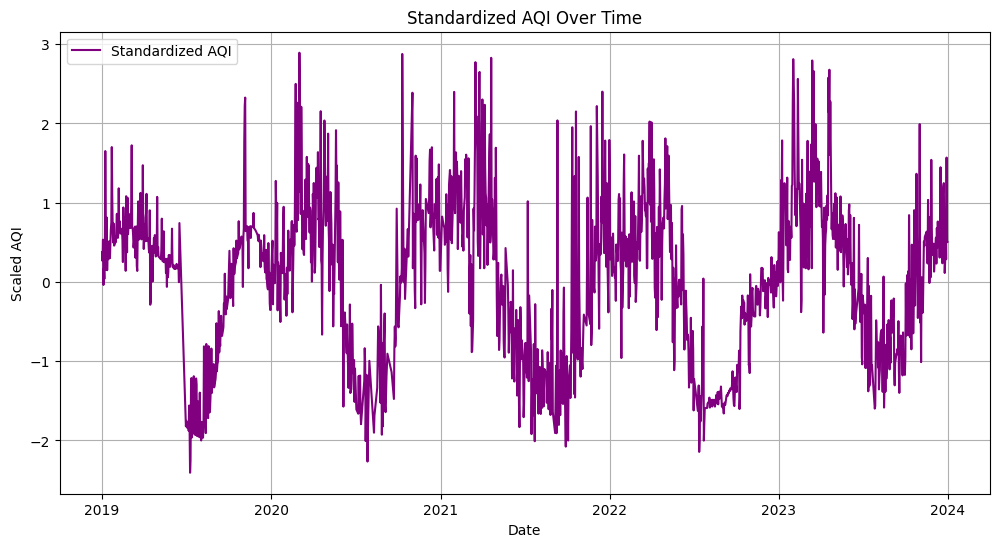

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('AQI_19-24(test).csv')  # Replace with actual file path
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Initial visualization of AQI over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['AQI'], label='Original AQI', color='blue')
plt.title('Original AQI Values Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid()
plt.show()

# Outlier analysis and handling
q1 = data['AQI'].quantile(0.25)
q3 = data['AQI'].quantile(0.75)
iqr = q3 - q1
outlier_mask = (data['AQI'] < (q1 - 1.5 * iqr)) | (data['AQI'] > (q3 + 1.5 * iqr))

# Highlight outliers in a scatter plot
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['AQI'], label='Original AQI', color='blue')
plt.scatter(data.index[outlier_mask], data['AQI'][outlier_mask], color='red', label='Outliers', alpha=0.7)
plt.title('Outliers in AQI Data')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid()
plt.show()

# Replace outliers with median value
data['AQI'] = np.where(outlier_mask, data['AQI'].median(), data['AQI'])

# Visualization after outlier treatment
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['AQI'], label='AQI After Outlier Treatment', color='green')
plt.title('AQI After Outlier Treatment')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid()
plt.show()

# Standardization
scaler = StandardScaler()
data['AQI_scaled'] = scaler.fit_transform(data[['AQI']])

# Visualization of scaled data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['AQI_scaled'], label='Standardized AQI', color='purple')
plt.title('Standardized AQI Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled AQI')
plt.legend()
plt.grid()
plt.show()


# feature creation

In [ ]:
# Lag and moving average features
data['AQI_7d'] = data['AQI_scaled'].shift(7)
data['AQI_14d'] = data['AQI_scaled'].shift(14)
data['AQI_30d'] = data['AQI_scaled'].shift(30)
data['AQI_7d_avg'] = data['AQI_scaled'].rolling(window=7).mean()
data['AQI_30d_avg'] = data['AQI_scaled'].rolling(window=30).mean()

# Drop NaN rows after feature engineering
data.dropna(inplace=True)

# Split into train/test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]


# hypertuning with gridsearchCV

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define features and labels
X_train, y_train = train.drop(columns=['AQI', 'AQI_scaled']), train['AQI']
X_test, y_test = test.drop(columns=['AQI', 'AQI_scaled']), test['AQI']

# Parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Grid Search with Cross-Validation
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters found: {grid_search.best_params_}")


Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [ ]:
import xgboost
print(xgboost.__version__)

2.1.2


In [ ]:
!pip install --upgrade xgboost

# model training with time series cross validation

In [ ]:
# Initialize time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Train XGBoost with the best parameters from grid search
best_xgb = xgb.XGBRegressor(objective='reg:squarederror', **grid_search.best_params_)
for train_idx, val_idx in tscv.split(X_train):
    X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    best_xgb.fit(X_t, y_t, eval_set=[(X_val, y_val)],  verbose=0)


# check for overfitting and underfitting

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate performance on training and validation sets
train_pred = best_xgb.predict(X_train)
val_pred = best_xgb.predict(X_val)

# Calculate multiple metrics
train_mae = mean_absolute_error(y_train, train_pred)
val_mae = mean_absolute_error(y_val, val_pred)
train_rmse = mean_squared_error(y_train, train_pred, squared=False)
val_rmse = mean_squared_error(y_val, val_pred, squared=False)
train_r2 = r2_score(y_train, train_pred)
val_r2 = r2_score(y_val, val_pred)

print(f"Training MAE: {train_mae}, Validation MAE: {val_mae}")
print(f"Training RMSE: {train_rmse}, Validation RMSE: {val_rmse}")
print(f"Training R^2: {train_r2}, Validation R^2: {val_r2}")

# Analyze the metrics:
if val_mae < train_mae and val_rmse < train_rmse and val_r2 > train_r2:
    print("Model is likely underfitting. Consider increasing model complexity or training data.")
elif val_mae > train_mae and val_rmse > train_rmse and val_r2 < train_r2:
    print("Model is likely overfitting. Consider reducing model complexity or increasing regularization.")
else:
    print("Model seems to be well-fitted.")

Training MAE: 4.830326560416554, Validation MAE: 3.3736371706637995
Training RMSE: 6.72036080399713, Validation RMSE: 5.096233850241814
Training R^2: 0.843998486248723, Validation R^2: 0.819462289795932
Model seems to be well-fitted.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# forcasting

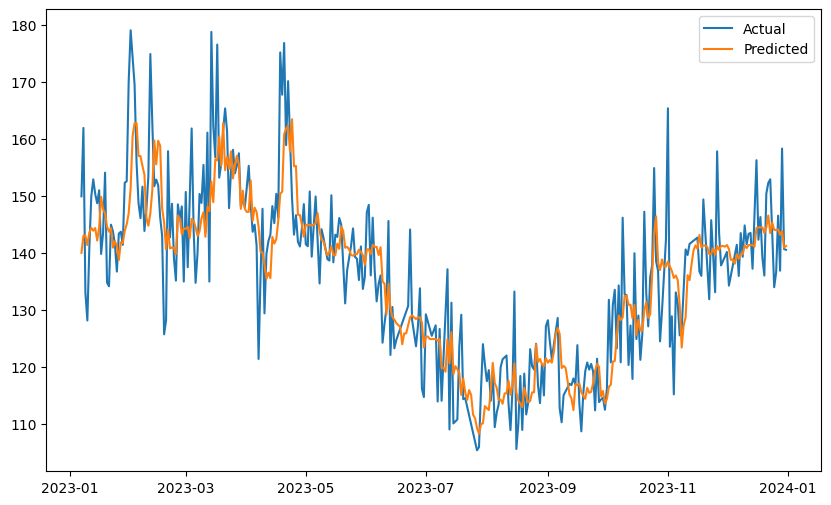

In [ ]:
# Forecast for the test set
test_predictions = best_xgb.predict(X_test)

# Plot actual vs predictions
plt.figure(figsize=(10, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, test_predictions, label='Predicted')
plt.legend()
plt.show()


# Evaluation Matrix

In [ ]:
def percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluate on test set
mae_test = mean_absolute_error(y_test, test_predictions)
rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
perc_error_test = percentage_error(y_test, test_predictions)

print(f"Test MAE: {mae_test}, Test RMSE: {rmse_test}, Test Percentage Error: {perc_error_test:.2f}%")


Test MAE: 5.82423526792539, Test RMSE: 7.702823306269952, Test Percentage Error: 4.23%


# future forcasting

<ipython-input-64-ca7725023a2e>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data.fillna(method='ffill', inplace=True)  # Or use other imputation methods as needed
<ipython-input-64-ca7725023a2e>:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future_data.fillna(method='ffill', inplace=True)  # Or use other imputation methods as needed


Future AQI Prediction MAE: 13.447954345179829


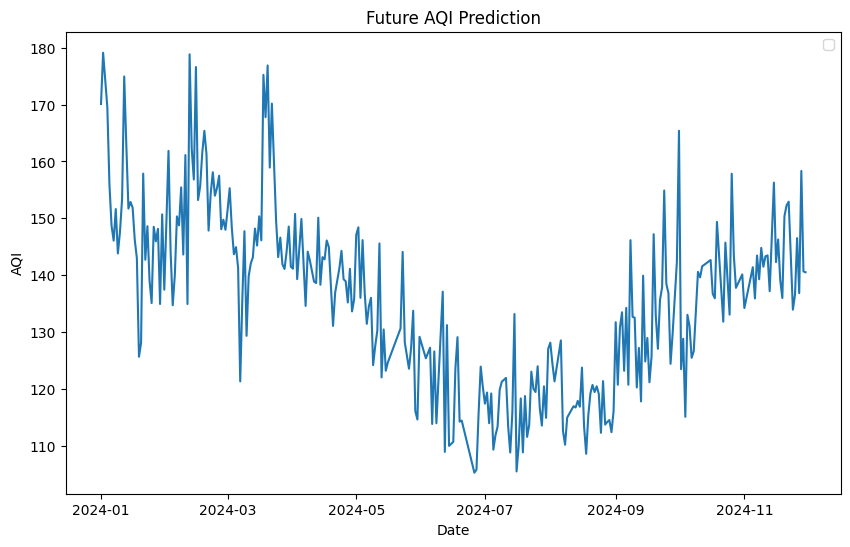

In [ ]:
# Set start date and calculate the number of days to predict
start_date = data.index[0]
year_end = pd.to_datetime(f"{start_date.year}-12-31")
days_to_predict = (year_end - start_date).days + 1

# Generate future index for predictions
future_periods = days_to_predict
future_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=future_periods, freq='D')

# Prepare future data with lag features
future_data = pd.DataFrame(index=future_index, columns=data.columns)
future_data['AQI_7d'] = data['AQI_scaled'].iloc[-7:].mean()
future_data['AQI_14d'] = data['AQI_scaled'].iloc[-14:].mean()
future_data['AQI_30d'] = data['AQI_scaled'].iloc[-30:].mean()
future_data['AQI_7d_avg'] = data['AQI_scaled'].rolling(window=7).mean().iloc[-1]
future_data['AQI_30d_avg'] = data['AQI_scaled'].rolling(window=30).mean().iloc[-1]

# Fill missing values
future_data.fillna(method='ffill', inplace=True)

# Predict future AQI using the model
future_forecast = best_xgb.predict(future_data.drop(columns=['AQI', 'AQI_scaled']))

# Evaluate and plot results if predictions are available
if len(future_forecast) > 0:
    future_actual = data['AQI'].iloc[-future_periods:]  # Use actual AQI data for evaluation
    mae = mean_absolute_error(future_actual, future_forecast)
    print(f"Future AQI Prediction MAE: {mae}")

    plt.figure(figsize=(10, 6))
    plt.plot(future_index, future_actual, label='Actual')
    plt.plot(future_index, future_forecast, label='Forecast')
    plt.legend()
    plt.title('Future AQI Prediction')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.show()
else:
    print("No future predictions available.")
